# Named Entity Recognition for Earthquake Tweets

### Install and Import the Packages

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
#!pip install seqeval

In [2]:
#!pip install transformers datasets

In [4]:
#!pip install transformers[torch]

In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer, pipeline
from datasets import load_dataset
from datasets import load_metric

### Upload the Dataset

In [6]:
jsonl_file_path = 'admin2.jsonl'


texts = []
with open(jsonl_file_path, 'r') as file:
    for line in file:
        data = json.loads(line.strip())
        texts.append(data)

In [7]:
df= pd.DataFrame(texts)
df.head()

,id,text,index,label,Comments
0,69825,"Turunçlu mahallesi samandag yolu uzeri, saray ...",22536,"[[0, 32, ADDR], [58, 68, ADDR], [69, 74, CITY]...",[]
1,69826,Kahramanmaraş ON İKİ ŞUBAT CADDESİ KÜLTÜRKENT ...,84306,"[[0, 13, CITY], [14, 52, ADDR], [112, 124, PER...",[]
2,69827,ŞAZİBEY MAHALLESİ HAYDAR ALİYEV BULVARI YUNUS ...,2888,"[[0, 62, ADDR]]",[]
3,69828,"Su otele yardım edin, çok çocuk var içeride. #...",36316,[],[]
4,69829,Malatya nergiz sitesi #malatyadeprem #Turkey #...,22886,"[[0, 7, CITY], [8, 21, ADDR]]",[]


In [8]:
df['text'][:5].tolist()

['Turunçlu mahallesi samandag yolu uzeri, saray market yanı 95/B Defne-Hatay Enkazda kalanlardan biri Nilay Oltacı İletişim 05161646506 #Turkey #CristianoRonaldo #hatayyardimbekliyor #hatayiskenderun #HalkTV #özgürdemirtaş #fulyaöztürk #EnkazAltında #tahaduymaz',
 'Kahramanmaraş ON İKİ ŞUBAT CADDESİ KÜLTÜRKENT SİTESİ ARKADAŞIMIN AMCASI KUZENİ ENKAZ ALTINDA LÜTFEN YARDIM EDİN VİLDAN GEZER ALİ GEZER #Kahramanmaras #deprem #Hatay #ENKAZALTİNDAYİM #Kahramanmaraş #Hatay #Turkey',
 'ŞAZİBEY MAHALLESİ HAYDAR ALİYEV BULVARI YUNUS APARTMANI A BLOK ACİLEN EKİBE İHTİYACIMIZ VAR LÜTFEN SESİMİZİ DUYURUN YARDIM EDİN #Turkey #Kahramanmaras #onikisubat #marasyardım #Marasayetisemiyoruz @haluklevent @ahbap @ekrem_imamoglu @berkcanguven @OguzhanUgur @efeuygac',
 'Su otele yardım edin, çok çocuk var içeride. #deprem #seferberlik #Turkey #YARDIMEDİN https://t.co/AP6oMgciQB',
 'Malatya nergiz sitesi #malatyadeprem #Turkey #TurkeyEarthquake #PrayForTurkey #sondakikadeprem https://t.co/j4mOfXZo7s']

### Clean The Data

Again, since I discovered some preparation requirements along the way, while moving further on the project, there were some necessary steps I realized only after finishing the annotation of the NER tags:
- the dataset I annotated was containing tags and hashtags, however, I realized they will end up being problematic and misleading for the machine learing since I observed people to use hashtags with many cities impacted by the earthquake at the end of their tweets to spread the word (ex: #hatay #malatya #kahramanmaraş) and I would not want the algorithm to confuse this as intentional location information. Similarly, they sometimes tagged the celebrities and government officials to spread the word and I would not want these to be mistaken as PERSON tags. So I decided to remove anything that follows these tags (not just # or @ symbols)
- Yet, there is a problem here: We cannot simply delete the entities following this tags since this would cause misalignment in the labeled dataset. As you see above, the labels were returned in such format: [0,32,ADDR] with numbers indicating the start and end indices of the corresponding string. 
- One solution is to replace ahh tags and hashtags characters with space, this way, the indices will remain the same. We can deal with these spaces later after tokenization.

In [9]:
def cleaned_text(text):
    chars_to_replace = r',/-"()*:'
    clean_text = re.sub(f'[{re.escape(chars_to_replace)}]', ' ', text)

    #remove any entity that follows @ and #
    i = 0
    while i < (len(clean_text)):
        if clean_text[i] == '@' or clean_text[i]== '#':
            a=0
            while i+a < len(clean_text):
                if clean_text[i+a] == ' ':
                    break
                else:
                    a += 1
            clean_text = clean_text[:i] + ' '*(a) + clean_text[i+a:]
        else:
            i+=1
    return clean_text

In [10]:
df2 = df.copy()
df2['text'] = df2['text'].apply(lambda x: cleaned_text(x))
df2['text'][:5].tolist()

['Turunçlu mahallesi samandag yolu uzeri  saray market yanı 95 B Defne Hatay Enkazda kalanlardan biri Nilay Oltacı İletişim 05161646506                                                                                                                              ',
 'Kahramanmaraş ON İKİ ŞUBAT CADDESİ KÜLTÜRKENT SİTESİ ARKADAŞIMIN AMCASI KUZENİ ENKAZ ALTINDA LÜTFEN YARDIM EDİN VİLDAN GEZER ALİ GEZER                                                                             ',
 'ŞAZİBEY MAHALLESİ HAYDAR ALİYEV BULVARI YUNUS APARTMANI A BLOK ACİLEN EKİBE İHTİYACIMIZ VAR LÜTFEN SESİMİZİ DUYURUN YARDIM EDİN                                                                                                                                              ',
 'Su otele yardım edin  çok çocuk var içeride.                                          https   t.co AP6oMgciQB',
 'Malatya nergiz sitesi                                                                          https   t.co j4mOfXZo7s']

In [11]:
df2['text'][0].split(" ")[:30]

['Turunçlu',
 'mahallesi',
 'samandag',
 'yolu',
 'uzeri',
 '',
 'saray',
 'market',
 'yanı',
 '95',
 'B',
 'Defne',
 'Hatay',
 'Enkazda',
 'kalanlardan',
 'biri',
 'Nilay',
 'Oltacı',
 'İletişim',
 '05161646506',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [12]:
df2['label'][0]

[[0, 32, 'ADDR'],
 [58, 68, 'ADDR'],
 [69, 74, 'CITY'],
 [100, 112, 'PER'],
 [122, 133, 'NUM']]

In [13]:
print(df2['text'][0][0:32])
print(df2['text'][0][58:68])
print(df2['text'][0][69:74])
print(df2['text'][0][100:112])
print(df2['text'][0][122:133])


Turunçlu mahallesi samandag yolu
95 B Defne
Hatay
Nilay Oltacı
05161646506


## Create Token-Tag Pairs
- The dataset originally have four tags : Person, City, Address and Number. However having noticed that category number is actually misleading for the machine, I decided to suppress that category and convert it to other.
Generating a Token called Other

In [18]:
#i decided to suppress tag Number because it serves little and creates confusion
for i in range(len(df2)):
  for j in range(len(df2['label'][i])) :
    if df2['label'][i][j][2] == 'NUM':
      new_tag = 'OTHER'
      df2['label'][i][j][2] = new_tag

df2['label'][0]

[[0, 32, 'ADDR'],
 [58, 68, 'ADDR'],
 [69, 74, 'CITY'],
 [100, 112, 'PER'],
 [122, 133, 'OTHER']]

In [21]:
all_token_tag_pairs = []
for i in range(len(df2)):
    all_tokens = df2['text'][i].split(" ")
    tokens_tags = []

    if len(df2['label'][i]) >0 :  #if there is any labeled entity in that sentence
        tokens_tags = []
        j = 0
        end_index = 0
        while j in range(len(df2['label'][i])) :
            start_index = df2['label'][i][j][0]  #start index of the label is the start index of first label-tag
            other_tokens = df2['text'][i][end_index:start_index].split(" ")
            #everything between the end index of previous token and start index of new token would be classified among other tokens

            if start_index > end_index:
                for token in other_tokens :
                    tokens_tags.append((token, "OTHER")) #let's classify all non-labeled tokens as other

            tag = df2['label'][i][j][2]
            end_index = df2['label'][i][j][1]

            labeled_tokens = df2['text'][i][start_index:end_index].split(" ") #we'll repeat the tag for each tokens of that entity

            if tag!= 'OTHER':
              for k in range(len(labeled_tokens)):
                if k == 0: #if k is the first token of that entity
                    tokens_tags.append((labeled_tokens[k],"B-"+tag))
                else:
                    tokens_tags.append((labeled_tokens[k], "I-"+tag))
            else: #if tag is other (former NUM - tags) no need for B- , I-
              for k in range(len(labeled_tokens)):
                tokens_tags.append((labeled_tokens[k], tag))

            j+=1 #move to the next labeled entity
            end_index = df2['label'][i][j-1][1] #update the end index


    else:
        tokens = df2['text'][i].split(" ")
        for token in tokens:
            tokens_tags.append((token, "OTHER"))

    all_token_tag_pairs.append(tokens_tags)







In [22]:
all_token_tag_pairs[0]

[('Turunçlu', 'B-ADDR'),
 ('mahallesi', 'I-ADDR'),
 ('samandag', 'I-ADDR'),
 ('yolu', 'I-ADDR'),
 ('', 'OTHER'),
 ('uzeri', 'OTHER'),
 ('', 'OTHER'),
 ('saray', 'OTHER'),
 ('market', 'OTHER'),
 ('yanı', 'OTHER'),
 ('', 'OTHER'),
 ('95', 'B-ADDR'),
 ('B', 'I-ADDR'),
 ('Defne', 'I-ADDR'),
 ('', 'OTHER'),
 ('', 'OTHER'),
 ('Hatay', 'B-CITY'),
 ('', 'OTHER'),
 ('Enkazda', 'OTHER'),
 ('kalanlardan', 'OTHER'),
 ('biri', 'OTHER'),
 ('', 'OTHER'),
 ('Nilay', 'B-PER'),
 ('Oltacı', 'I-PER'),
 ('', 'OTHER'),
 ('İletişim', 'OTHER'),
 ('', 'OTHER'),
 ('05161646506', 'OTHER')]

We can confirm that the labels I assigned "NUM" during annotation were correctly replaced by "OTHER".

In [23]:
tags = []

for pair in all_token_tag_pairs:
  for token,tag in pair:
    tags.append(tag)

set(tags)

{'B-ADDR', 'B-CITY', 'B-PER', 'I-ADDR', 'I-CITY', 'I-PER', 'OTHER'}

Now that we won't need to the characters indices anymore, every token separately labeled, we can get rid of the empty space tokens.

In [24]:
new_pairs = []
for tweet in all_token_tag_pairs:
    new_tweet = []
    for token,tag in tweet:
        if token != '':
            new_tweet.append((token,tag))
    new_pairs.append(new_tweet)

new_pairs[:30]

[[('Turunçlu', 'B-ADDR'),
  ('mahallesi', 'I-ADDR'),
  ('samandag', 'I-ADDR'),
  ('yolu', 'I-ADDR'),
  ('uzeri', 'OTHER'),
  ('saray', 'OTHER'),
  ('market', 'OTHER'),
  ('yanı', 'OTHER'),
  ('95', 'B-ADDR'),
  ('B', 'I-ADDR'),
  ('Defne', 'I-ADDR'),
  ('Hatay', 'B-CITY'),
  ('Enkazda', 'OTHER'),
  ('kalanlardan', 'OTHER'),
  ('biri', 'OTHER'),
  ('Nilay', 'B-PER'),
  ('Oltacı', 'I-PER'),
  ('İletişim', 'OTHER'),
  ('05161646506', 'OTHER')],
 [('Kahramanmaraş', 'B-CITY'),
  ('ON', 'B-ADDR'),
  ('İKİ', 'I-ADDR'),
  ('ŞUBAT', 'I-ADDR'),
  ('CADDESİ', 'I-ADDR'),
  ('KÜLTÜRKENT', 'I-ADDR'),
  ('SİTESİ', 'I-ADDR'),
  ('ARKADAŞIMIN', 'OTHER'),
  ('AMCASI', 'OTHER'),
  ('KUZENİ', 'OTHER'),
  ('ENKAZ', 'OTHER'),
  ('ALTINDA', 'OTHER'),
  ('LÜTFEN', 'OTHER'),
  ('YARDIM', 'OTHER'),
  ('EDİN', 'OTHER'),
  ('VİLDAN', 'B-PER'),
  ('GEZER', 'I-PER'),
  ('ALİ', 'B-PER'),
  ('GEZER', 'I-PER')],
 [('ŞAZİBEY', 'B-ADDR'),
  ('MAHALLESİ', 'I-ADDR'),
  ('HAYDAR', 'I-ADDR'),
  ('ALİYEV', 'I-ADDR'),
  ('BUL

## Encoding the Labels to Integers

In [25]:
ner_tags = ["OTHER", 'B-PER', 'I-PER', 'B-CITY', 'I-CITY', 'B-ADDR', 'I-ADDR']
id2label = {k: v for k, v in enumerate(ner_tags)}
label2id = {v: k for k, v in id2label.items()}

In [26]:
id2label

{0: 'OTHER',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-CITY',
 4: 'I-CITY',
 5: 'B-ADDR',
 6: 'I-ADDR'}

In [27]:
label2id

{'OTHER': 0,
 'B-PER': 1,
 'I-PER': 2,
 'B-CITY': 3,
 'I-CITY': 4,
 'B-ADDR': 5,
 'I-ADDR': 6}

### Separating tokens and *tags*

In [28]:
inputs = []
targets = []

for tweet_tag_pairs in new_pairs:
    tokens = []
    target = []
    for token, tag in tweet_tag_pairs:
        tokens.append(token)
        target.append(label2id[tag])
    inputs.append(tokens)
    targets.append(target)

In [29]:
inputs[:5]

[['Turunçlu',
  'mahallesi',
  'samandag',
  'yolu',
  'uzeri',
  'saray',
  'market',
  'yanı',
  '95',
  'B',
  'Defne',
  'Hatay',
  'Enkazda',
  'kalanlardan',
  'biri',
  'Nilay',
  'Oltacı',
  'İletişim',
  '05161646506'],
 ['Kahramanmaraş',
  'ON',
  'İKİ',
  'ŞUBAT',
  'CADDESİ',
  'KÜLTÜRKENT',
  'SİTESİ',
  'ARKADAŞIMIN',
  'AMCASI',
  'KUZENİ',
  'ENKAZ',
  'ALTINDA',
  'LÜTFEN',
  'YARDIM',
  'EDİN',
  'VİLDAN',
  'GEZER',
  'ALİ',
  'GEZER'],
 ['ŞAZİBEY',
  'MAHALLESİ',
  'HAYDAR',
  'ALİYEV',
  'BULVARI',
  'YUNUS',
  'APARTMANI',
  'A',
  'BLOK'],
 ['Su',
  'otele',
  'yardım',
  'edin',
  'çok',
  'çocuk',
  'var',
  'içeride.',
  'https',
  't.co',
  'AP6oMgciQB'],
 ['Malatya', 'nergiz', 'sitesi']]

In [30]:
targets[:5]

[[5, 6, 6, 6, 0, 0, 0, 0, 5, 6, 6, 3, 0, 0, 0, 1, 2, 0, 0],
 [3, 5, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2],
 [5, 6, 6, 6, 6, 6, 6, 6, 6],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3, 5, 6]]

### Save the input-tag pairs as a new dataset

In [31]:
with open('NER_deneme.json', 'w') as f:
  for x, y in zip(inputs, targets):
    j = {'inputs': x, 'targets': y}
    s = json.dumps(j)
    f.write(f"{s}\n")

In [42]:
dataset = load_dataset("json", data_files='NER_deneme.json')

In [43]:
dataset

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 1352
    })
})

In [44]:
data = dataset['train'].train_test_split(seed=42)
data

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 338
    })
})

### Import the pretrained model we will fine-tune

In [45]:
checkpoint = "akdeniz27/bert-base-turkish-cased-ner"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


 Let's find out how the model's tokenizer will treat the tokens

In [46]:
#ex
t = tokenizer(data['train'][1]['inputs'], is_split_into_words = True)
t

{'input_ids': [2, 11186, 28960, 24344, 5020, 10365, 14258, 9360, 3204, 7906, 12490, 26300, 3884, 554, 4079, 5263, 1040, 37, 4084, 1071, 9742, 1128, 10451, 18376, 16465, 15170, 2067, 3013, 6283, 4249, 18, 3256, 1006, 11602, 1974, 4542, 11262, 11602, 1974, 16515, 11602, 1974, 31505, 1050, 11602, 1974, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [47]:
t.tokens()

['[CLS]',
 'Hatay',
 'Antakya',
 'Bedi',
 'Sab',
 '##uncu',
 'İlköğretim',
 'Okulu',
 'yanı',
 'Tor',
 '##unlar',
 'Apart',
 '##manı',
 '’',
 'nda',
 'TÜ',
 '##M',
 'A',
 '##İL',
 '##E',
 'GÖ',
 '##Ç',
 '##ÜK',
 'ALT',
 '##INDA',
 'saatler',
 '##dir',
 'haber',
 'alına',
 '##mıyor',
 '.',
 'Sen',
 '##a',
 'Alk',
 '##an',
 'Ahmet',
 'Cengiz',
 'Alk',
 '##an',
 'Fikret',
 'Alk',
 '##an',
 'Yağı',
 '##z',
 'Alk',
 '##an',
 '[SEP]']

### Attention:
- As in other transformer models,  the tokenizer generated subword tokens, by splitting the words into sub-units.
- This will cause an alignment problem with our target tags, since now the input data is longer than the targets.
- Therefore we will need to realign the targets.

To this end, we will use the word_ids() method of the Transformer Tokenizer class. This method returns us the value i for each subword token, with i denoting that the corresponding token belongs to the i'th word of the input sentence. Since the first token of each sentence is [CLS] and last token is [SEP], these two receive 'None' as word_ids value, as they do not originally belong to the sentence.

In [48]:
#target alignment:
# value of i indicates it is the i'th word
# in the input sentence (counting from 0)
t.word_ids()

[None,
 0,
 1,
 2,
 3,
 3,
 4,
 5,
 6,
 7,
 7,
 8,
 8,
 8,
 8,
 9,
 9,
 10,
 10,
 10,
 11,
 11,
 11,
 12,
 12,
 13,
 13,
 14,
 15,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 19,
 20,
 20,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 None]

In order to realign the targets, we will make sure that subword tokens that belong to the same word will share the same tag, but in different I or B tags. For example, we know that the first word in a person entity received the B-PER tag, while the following words belonging to the same entity recieved I-PER. This time, we will make sure that after the subword tokenization, even the subword tokens within the first word of a person entity will start with B-PER and continue as I-PER. We don't have any problem if the word's corresponding tag is already I-PER (like a second word in an entity), in that case we can directly replicate the I-PER tag for all sub-units.

Since the change must be done only for the subsequent tokens that are part of the first word of an entity, let's designate a function that will convert from label "B-" to label "I-" for those tokens, and that will replicate label "I-" for the other parts of the entities.

In [49]:
# ["OTHER", 'B-PER', 'I-PER', 'B-CITY', 'I-CITY', 'B-ADDR', 'I-ADDR']

begin2inside = {
  1: 2,
  3: 4,
  5: 6,
}

Note that in NER and POS tagging we often encode as a negative value -100 for the CLS and SEP tokens as a common practice to easily filter them out when needed.

In [50]:
def align_targets(labels, word_ids):
    #word_ids list has the same length as tokenized inputs
    #labels are just the original labels so they have the same length as untokenized inputs
  aligned_labels = []
  last_assigned_word = None
  for word_id in word_ids:
    if word_id is None:
      # it's a token like [CLS]
      label = -100
    elif word_id != last_assigned_word:  #this means the token is not belonging to the previous word
      # it's a new word!
      label = labels[word_id]
    else:
      # it's the same word as before
      #so we should map them to a I-tag not B-tag
      label = labels[word_id]
        #however we should have some way to check this label I- B- cause we can't have more than one B

      # change B-<tag> to I-<tag> if necessary
      if label in begin2inside: #remember label is an id mapped to corresponding tag
        label = begin2inside[label]

    # add the label
    aligned_labels.append(label)

    # update last word
    last_assigned_word = word_id

  return aligned_labels


In [51]:
# try our function for the tokens stored in t, corresponding to input index 1
labels = data['train'][1]['targets'] #these are the non-aligned NER tags for that input
word_ids = t.word_ids()
aligned_targets = align_targets(labels, word_ids)


In [52]:
" ".join(data['train'][1]['inputs'])

'Hatay Antakya Bedi Sabuncu İlköğretim Okulu yanı Torunlar Apartmanı’nda TÜM AİLE GÖÇÜK ALTINDA saatlerdir haber alınamıyor. Sena Alkan Ahmet Cengiz Alkan Fikret Alkan Yağız Alkan'

In [53]:
#let's retrieve the corresponding label from our id2label dictionary:
#the code below will return id2label tags for positive id and None for negative id (-100 in our case)
aligned_labels = [ner_tags[t] if t >= 0 else None for t in aligned_targets] #-100se none alcak

for x, y in zip(t.tokens(), aligned_labels):
  print(f"{x}\t{y}")

[CLS]	None
Hatay	B-CITY
Antakya	B-ADDR
Bedi	I-ADDR
Sab	I-ADDR
##uncu	I-ADDR
İlköğretim	I-ADDR
Okulu	I-ADDR
yanı	OTHER
Tor	B-ADDR
##unlar	I-ADDR
Apart	I-ADDR
##manı	I-ADDR
’	I-ADDR
nda	I-ADDR
TÜ	OTHER
##M	OTHER
A	OTHER
##İL	OTHER
##E	OTHER
GÖ	OTHER
##Ç	OTHER
##ÜK	OTHER
ALT	OTHER
##INDA	OTHER
saatler	OTHER
##dir	OTHER
haber	OTHER
alına	OTHER
##mıyor	OTHER
.	OTHER
Sen	B-PER
##a	I-PER
Alk	I-PER
##an	I-PER
Ahmet	B-PER
Cengiz	I-PER
Alk	I-PER
##an	I-PER
Fikret	B-PER
Alk	I-PER
##an	I-PER
Yağı	B-PER
##z	I-PER
Alk	I-PER
##an	I-PER
[SEP]	None


All tags seem to have been aligned correctly!

Now we are ready to build a custom tokenizer, which will apply tokenizer to the entire dataset and while aligning the labels accordingly!

In [54]:
# tokenize both inputs and targets
def tokenize_fn(batch):
  # tokenize the input sequence first
  # this populates input_ids, attention_mask, etc.
  tokenized_inputs = tokenizer(
    batch['inputs'], truncation=True, is_split_into_words=True
  )

  labels_batch = batch['targets'] # original targets
  aligned_labels_batch = []
  for i, labels in enumerate(labels_batch):
    word_ids = tokenized_inputs.word_ids(i)
    aligned_labels_batch.append(align_targets(labels, word_ids))

  # recall: the 'target' must be stored in key called 'labels'
  tokenized_inputs['labels'] = aligned_labels_batch

  return tokenized_inputs

In [56]:
tokenized_datasets = data.map(
  tokenize_fn,
  batched=True,
  remove_columns=data["train"].column_names, #this is in case the data contain columns other than input and labels
)

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/338 [00:00<?, ? examples/s]

In [57]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 338
    })
})

### Data Collator

In [58]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [59]:
metric = load_metric("seqeval")

<ipython-input-59-e20ba34f8cc7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [60]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  preds = np.argmax(logits, axis=-1)

  # remove -100 from labels and predictions
  # and convert the label_ids to label names
  str_labels = [
    [id2label[t] for t in label if t != -100] for label in labels
  ] #only returns the labels for id != -100

  # do the same for predictions whenever true label is -100,
  # because we don't want our models predictions over the CLS and SEP tags (which will likely be %100 correct
  # to bias and overestimate the performance of our model)

  str_preds = [
    [id2label[p] for p, t in zip(pred, targ) if t != -100] for pred, targ in zip(preds, labels)
  ] #for every case that the original label is -100, the prediction will be removed without being taken into account

  the_metrics = metric.compute(predictions=str_preds, references=str_labels)
    #from here we format the result into a new dictionary
  return {
    'precision': the_metrics['overall_precision'],
    'recall': the_metrics['overall_recall'],
    'f1': the_metrics['overall_f1'],
    'accuracy': the_metrics['overall_accuracy'],
  }


In [66]:
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    #ignore_mismatched_sizes=True,
    #there is no longer need for this after suppressing NUM label, now the number of labels in our data
    #matches the number of labels in the pre-trained model
)

In [67]:
training_args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=6,
    weight_decay=0.01,
)

In [68]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator, ### the only difference from previous section
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.182862,0.757705,0.797539,0.777112,0.947714
2,No log,0.162922,0.790822,0.828859,0.809394,0.956199
3,No log,0.162030,0.823466,0.855705,0.839276,0.961502
4,0.155800,0.173398,0.830819,0.862416,0.846323,0.962562
5,0.155800,0.177433,0.822771,0.856823,0.839452,0.962774
6,0.155800,0.181278,0.822650,0.861298,0.841530,0.963411


TrainOutput(global_step=762, training_loss=0.11245356707435268, metrics={'train_runtime': 153.5254, 'train_samples_per_second': 39.629, 'train_steps_per_second': 4.963, 'total_flos': 173094470476488.0, 'train_loss': 0.11245356707435268, 'epoch': 6.0})

In [69]:
trainer.save_model('my_saved_model')

### Building Pipeline and Testing the Model
Notice that I name this first pipeline pipe_none, referring to the fact that I did not choose any aggregation strategy and I will receive the predictions for subword units.

Let's see how this model will perform on the train and validation sets.

In [70]:
pipe_none = pipeline(
  "token-classification",
  model='my_saved_model',
  device=0,
)

In [71]:
def flatten(list_of_lists):
  flattened = [item for sublist in list_of_lists for item in sublist]
  return flattened


We know that our inputs are tags are normally formatted as list of lists, where each sublist in the main list corresponds to input sentences and each item in the sublist corresponds to tokens.

To evaluate the performance metrics, I will define a flatten function that would convert these nested lists into a single list. And then I will apply the metrics defined above to assess model performances.

### Attention:
Note that there is a degree of naivety with this approach. For each metric, it takes into account the number of False Positives, False Negatives, True Positives and True Negatives in the sample, and returns us accuracy, f1, precision and recall scores.

This approach relies on the assumption that the predictions on the labels assigned to the tokens are independent from each other and thus can reflect the model performance. However, this is rarely the case, since the model's prediction of a previous token likely to affect its prediction on the next token, this might especially be case for the subword tokens belonging to the same word. Therefore, in reality, predictions can be interdependent and chaning one can lead the model to change several others too.

But for the sake of simplicity, I will neglect this bias in the performance metrics and take them as an acceptable indicator of the performance.

In [72]:
val_pred_none = pipe_none(flatten(data['test']['inputs']))
train_pred_none = pipe_none(flatten(data['train']['inputs']))
val_pred_none[:20]

[[{'entity': 'OTHER',
   'score': 0.99949443,
   'index': 1,
   'word': 'lütfen',
   'start': 0,
   'end': 6}],
 [{'entity': 'OTHER',
   'score': 0.99755704,
   'index': 1,
   'word': 'yardım',
   'start': 0,
   'end': 6}],
 [{'entity': 'OTHER',
   'score': 0.9512494,
   'index': 1,
   'word': 'edin',
   'start': 0,
   'end': 4}],
 [{'entity': 'B-PER',
   'score': 0.99242413,
   'index': 1,
   'word': 'BİL',
   'start': 0,
   'end': 3},
  {'entity': 'I-PER',
   'score': 0.99730504,
   'index': 2,
   'word': '##AL',
   'start': 3,
   'end': 5}],
 [{'entity': 'B-PER',
   'score': 0.9064579,
   'index': 1,
   'word': 'YILMAZ',
   'start': 0,
   'end': 6},
  {'entity': 'I-PER',
   'score': 0.9753887,
   'index': 2,
   'word': '##LAR',
   'start': 6,
   'end': 9}],
 [{'entity': 'OTHER',
   'score': 0.7589782,
   'index': 1,
   'word': 'VE',
   'start': 0,
   'end': 2}],
 [{'entity': 'OTHER',
   'score': 0.9997892,
   'index': 1,
   'word': 'BA',
   'start': 0,
   'end': 2},
  {'entity': 'OT

In [73]:
target_tags_val = flatten(tokenized_datasets["test"]['labels'])
target_tags_train = flatten(tokenized_datasets["train"]['labels'])
print("The number of the NER tags in the training set:", len(target_tags_train))
print("The number of the NER tags in the validation set:", len(target_tags_val))

The number of the NER tags in the training set: 29566
The number of the NER tags in the validation set: 10105


Remember that we had inserted the tags for CLS and SEP tokens in order to be able to train the model, yet these are not present in the predictions the model returns nor do we want them to be as we don't want them to bias our performance metrics. So let's drop tags -100 from our actual targets.

In [74]:
print("The number of -100 tags we inserted in the training set:", target_tags_train.count(-100))
print("The number of -100 tags we inserted in the validation set:", target_tags_val.count(-100))


The number of -100 tags we inserted in the training set: 2028
The number of -100 tags we inserted in the validation set: 676


In [75]:
targ_train_labels = [x for x in target_tags_train if x != -100]
targ_val_labels = [x for x in target_tags_val if x != -100]
print("New number of the NER tags in the training set:", len(targ_train_labels))
print("New number of the NER tags in the validation set:", len(targ_val_labels))


New number of the NER tags in the training set: 27538
New number of the NER tags in the validation set: 9429


We have confirmed that the length of targets and predictions match both for train and valdiation set. Now let's check out the metric scores.

In [76]:
pred_labels_train = []
for item in train_pred_none:
  for j in item:
    pred_labels_train.append(label2id[j['entity']])

pred_labels_val = []
for item in val_pred_none:
  for j in item:
    pred_labels_val.append(label2id[j['entity']])

print("The number of predicted labels for the training set:", len(pred_labels_train))
print("The number of predicted labels for the validation set:", len(pred_labels_val))

The number of predicted labels for the training set: 27538
The number of predicted labels for the validation set: 9429


In [77]:
print("train_accuracy:", accuracy_score(targ_train_labels, pred_labels_train))
print("train_f1:", f1_score(targ_train_labels, pred_labels_train, average='macro'))

print("val_accuracy:", accuracy_score(targ_val_labels, pred_labels_val))
print("val_f1:", f1_score(targ_val_labels, pred_labels_val, average='macro'))


train_accuracy: 0.7318977413029268
train_f1: 0.6415339351175782
val_accuracy: 0.7275426874536006
val_f1: 0.6263596572807624


Let's visualize the precision and recall scores for each label in a table.


In [78]:
print("Train Set Precision and Recall")
pd.concat([pd.Series(id2label.values()),
          pd.Series(precision_score(targ_train_labels, pred_labels_train, average=None)),
          pd.Series(recall_score(targ_train_labels, pred_labels_train, average=None))], keys = ['tags', 'precision', 'recall'], axis=1)


Train Set Precision and Recall


,tags,precision,recall
0,OTHER,0.834399,0.913832
1,B-PER,0.292752,0.930142
2,I-PER,0.519984,0.551948
3,B-CITY,0.700967,0.985167
4,I-CITY,0.602057,0.952441
5,B-ADDR,0.380348,0.553502
6,I-ADDR,0.920866,0.478600


In [79]:
print("Validation Set Precision and Recall")
pd.concat([pd.Series(id2label.values()),
          pd.Series(precision_score(targ_val_labels, pred_labels_val, average=None)),
          pd.Series(recall_score(targ_val_labels, pred_labels_val, average=None))], keys = ['tags', 'precision', 'recall'], axis=1)


Validation Set Precision and Recall


,tags,precision,recall
0,OTHER,0.838856,0.898584
1,B-PER,0.306122,0.895522
2,I-PER,0.501940,0.494268
3,B-CITY,0.679894,0.977186
4,I-CITY,0.568293,0.913725
5,B-ADDR,0.383877,0.557103
6,I-ADDR,0.863362,0.466016


In [93]:
classes = ner_tags
def plot_cm(ax, cm, title):
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    sns.heatmap(df_cm, annot=True, fmt='.2f', ax = ax, cmap= 'YlGnBu')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
    ax.set_title(title)

In [81]:
P_train = [id2label[x] for x in pred_labels_train ]
Y_train = [id2label[x] for x in targ_train_labels ]
P_test = [id2label[x] for x in pred_labels_val ]
Y_test = [id2label[x] for x in targ_val_labels ]

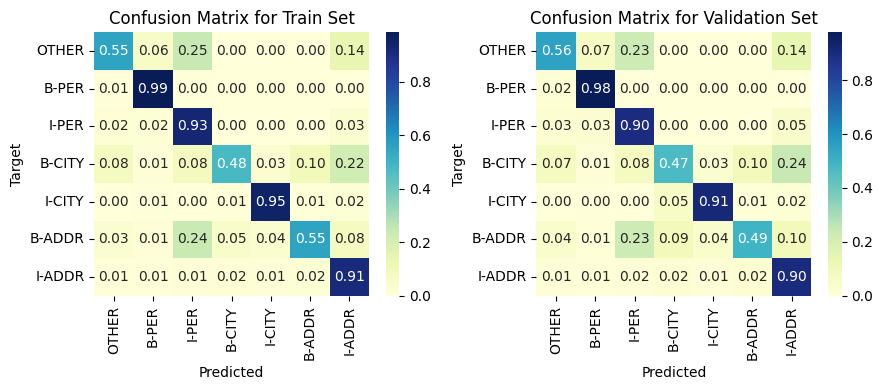

In [85]:
cm_train = confusion_matrix(Y_train,P_train, normalize='true')
cm_val = confusion_matrix(Y_test,P_test, normalize='true')


fig, axes = plt.subplots(1, 2, figsize=(9,4))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')

plt.tight_layout()
plt.show()

In [86]:
aggr_tags = ['OTHER', 'PER', 'CITY', 'ADDR']
id2label_aggr = {k: v for k, v in enumerate(aggr_tags)}
label2id_aggr = {v: k for k, v in id2label_aggr.items()}
label2id_aggr

{'OTHER': 0, 'PER': 1, 'CITY': 2, 'ADDR': 3}

In [87]:
aggr_pred_train = []
for i in range(len(pred_labels_train)):
  if pred_labels_train[i] == 0:
    aggr_pred_train.append(0)
  else:
    tag = id2label[pred_labels_train[i]][2:]
    aggr_pred_train.append(aggr_tags.index(tag))

aggr_pred_val = []
for i in range(len(pred_labels_val)):
  if pred_labels_val[i] == 0:
    aggr_pred_val.append(0)
  else:
    tag = id2label[pred_labels_val[i]][2:]
    aggr_pred_val.append(aggr_tags.index(tag))


In [89]:
aggr_target_train = []
for i in range(len(targ_train_labels)):
  if targ_train_labels[i] == 0:
    aggr_target_train.append(0)
  else:
    tag = id2label[targ_train_labels[i]][2:]
    aggr_target_train.append(aggr_tags.index(tag))

aggr_target_val = []
for i in range(len(targ_val_labels)):
  if targ_val_labels[i] == 0:
    aggr_target_val.append(0)
  else:
    tag = id2label[targ_val_labels[i]][2:]
    aggr_target_val.append(aggr_tags.index(tag))


In [90]:
print("train_accuracy:", accuracy_score(aggr_target_train, aggr_pred_train))
print("train_f1:", f1_score(aggr_target_train, aggr_pred_train, average='macro'))

print("val_accuracy:", accuracy_score(aggr_target_val, aggr_pred_val))
print("val_f1:", f1_score(aggr_target_val, aggr_pred_val, average='macro'))


train_accuracy: 0.7767085481879584
train_f1: 0.7434247318645726
val_accuracy: 0.7682681090253474
val_f1: 0.7241261395449156


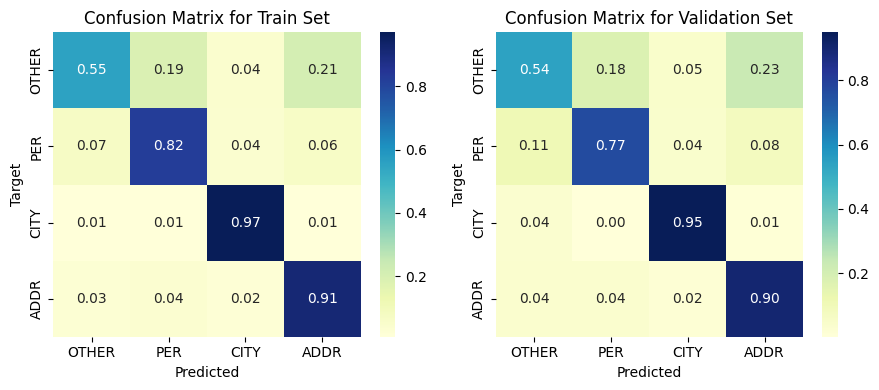

In [94]:
P_train = [id2label[x] for x in aggr_pred_train ]
Y_train = [id2label[x] for x in aggr_target_train ]
P_test = [id2label[x] for x in aggr_pred_val ]
Y_test = [id2label[x] for x in aggr_target_val]

classes=aggr_tags

cm_train = confusion_matrix(Y_train,P_train, normalize='true')
cm_val = confusion_matrix(Y_test,P_test, normalize='true')


fig, axes = plt.subplots(1, 2, figsize=(9,4))
plot_cm(axes[0], cm_train, title='Confusion Matrix for Train Set')
plot_cm(axes[1], cm_val, title='Confusion Matrix for Validation Set')

plt.tight_layout()
plt.show()

In [132]:
join_tweets = []
for tweet in data['test']['inputs']:
  joined = ' '.join(tweet)
  join_tweets.append(joined)

predictions = []
false_predictions = []

for tweet in join_tweets:
  result = pipe_none(tweet)
  tweet_preds = []
  tweet_preds.append(-100)
  for token in result:
    tweet_preds.append(label2id[token['entity']])
  tweet_preds.append(-100)
  predictions.append(tweet_preds)

  if tweet_preds != tokenized_datasets['test']['labels'][join_tweets.index(tweet)]:
    false_predictions.append(tweet)


In [124]:
print("The number of false predited tags in the test set is", len(false_predictions))

The number of false predited tags in the test set is 101


In [133]:
false_results = pipe_none(false_predictions)

In [141]:
N = 3
for item in false_results[N]:
  print(item['entity'], item['word'])

OTHER 53
OTHER saat
OTHER oldu
OTHER V
OTHER ##İN
OTHER ##Ç
OTHER L
OTHER ##AZ
OTHER ##IM
OTHER SE
OTHER ##S
OTHER VAR
OTHER TER
OTHER ##MA
OTHER ##L
OTHER KAM
OTHER ##ER
OTHER ##A
OTHER İLE
OTHER TE
OTHER ##Y
OTHER ##İT
OTHER ED
OTHER ##İL
OTHER ##Dİ
B-CITY K
I-CITY .
I-CITY Kahramanmaraş
B-ADDR Dul
I-ADDR ##kadir
I-ADDR ##oğlu
I-ADDR Trabzon
I-ADDR Caddesi
I-ADDR .
I-ADDR şe
I-ADDR ##lal
OTHER ##e
OTHER park
OTHER karşı
OTHER ##sı
B-ADDR Barbaros
I-ADDR Apart
I-ADDR ##manı
I-ADDR .
OTHER enkaz
OTHER altında
B-PER Ayşe
I-PER Yiğit
B-PER Fatih
I-PER Yiğit
B-PER Erhan
I-PER Yiğit


In [144]:
N = 2
for item in false_results[N]:
  print(item['entity'], item['word'])

B-CITY Kahramanmaraş
B-ADDR Elma
I-ADDR ##lar
I-ADDR Köyü
OTHER Arkadaş
OTHER ##ımızdan
OTHER haber
OTHER aldık
OTHER kendisi
OTHER bize
OTHER ulaştı
OTHER soğu
OTHER ##ğa
OTHER dayanama
OTHER ##dıklarını
OTHER söyledi
OTHER lütfen
OTHER yardım
OTHER edin
OTHER Hiç
OTHER bir
OTHER yardım
OTHER ekibi
OTHER bölgeye
OTHER halen
OTHER ulaşma
OTHER ##dığını
OTHER belirtti
B-PER Yusuf
I-PER Karab
I-PER ##ör
I-PER ##k


In [146]:
N = 90
for item in false_results[N]:
  print(item['entity'], item['word'])

B-PER Burcu
I-PER Ünal
OTHER sağlık
OTHER hizmetleri
OTHER meslek
OTHER yüksekokul
OTHER ##u
OTHER radyo
OTHER ##terapi
OTHER öğrencisi
OTHER El
I-ADDR ##bistan
I-CITY ##day
OTHER ##mış
OTHER durumu
OTHER kötü
OTHER ##ym
OTHER ##üş
OTHER ulaş
OTHER ##amıyoruz
OTHER ulaşan
OTHER var
OTHER mı
OTHER ?
OTHER Bu
OTHER numara
OTHER ##ya
OTHER ilet
OTHER ##ebilirsiniz
B-PER burcu
I-PER ün
I-PER ##al
I-PER '
I-PER dan
OTHER haber
OTHER aldığınız
OTHER ##da
OTHER .
OTHER 02
OTHER ##32
OTHER 41
OTHER ##2
OTHER 14
OTHER 11


In [152]:
pipe_first = pipeline(
  "token-classification",
  model='my_saved_model',
  aggregation_strategy = "first",
  device=0,
)


In [150]:
pipe_first(false_predictions[3])

[{'entity_group': 'OTHER',
  'score': 0.9999667,
  'word': '53 saat oldu VİNÇ LAZIM SES VAR TERMAL KAMERA İLE TEYİT EDİLDİ',
  'start': 0,
  'end': 62},
 {'entity_group': 'CITY',
  'score': 0.8604784,
  'word': 'K. Kahramanmaraş',
  'start': 63,
  'end': 78},
 {'entity_group': 'ADDR',
  'score': 0.9782299,
  'word': 'Dulkadiroğlu Trabzon Caddesi. şelale',
  'start': 79,
  'end': 115},
 {'entity_group': 'OTHER',
  'score': 0.8524765,
  'word': 'park karşısı',
  'start': 116,
  'end': 128},
 {'entity_group': 'ADDR',
  'score': 0.9900317,
  'word': 'Barbaros Apartmanı.',
  'start': 129,
  'end': 148},
 {'entity_group': 'OTHER',
  'score': 0.9999409,
  'word': 'enkaz altında',
  'start': 149,
  'end': 162},
 {'entity_group': 'PER',
  'score': 0.9959035,
  'word': 'Ayşe Yiğit',
  'start': 163,
  'end': 173},
 {'entity_group': 'PER',
  'score': 0.9971923,
  'word': 'Fatih Yiğit',
  'start': 174,
  'end': 185},
 {'entity_group': 'PER',
  'score': 0.99807143,
  'word': 'Erhan Yiğit',
  'start'

In [153]:
pipe_first(false_predictions[90])

[{'entity_group': 'PER',
  'score': 0.9943818,
  'word': 'Burcu Ünal',
  'start': 0,
  'end': 10},
 {'entity_group': 'OTHER',
  'score': 0.967922,
  'word': 'sağlık hizmetleri meslek yüksekokulu radyoterapi öğrencisi Elbistandaymış durumu kötüymüş ulaşamıyoruz ulaşan var mı? Bu numaraya iletebilirsiniz',
  'start': 11,
  'end': 156},
 {'entity_group': 'PER',
  'score': 0.9360368,
  'word': "burcu ünal ' dan",
  'start': 157,
  'end': 171},
 {'entity_group': 'OTHER',
  'score': 0.99996346,
  'word': 'haber aldığınızda. 0232 412 14 11',
  'start': 172,
  'end': 205}]

In [154]:
!pip install huggingface_hub

In [155]:
import huggingface_hub

In [157]:
!huggingface-cli login
!huggingface-cli repo create turkish-earthquake-tweets-ner


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-crede

In [156]:
!huggingface-cli login
!huggingface-cli repo create turkish-earthquake-tweets-ner-bert


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' creden

In [ ]:
huggingface_hub.upload_folder(folder_path='my_saved_model',
    repo_id="yhaslan/turkish-earthquake-tweets-ner",
    repo_type="model"
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

'https://huggingface.co/yhaslan/turkish-earthquake-tweets-ner/tree/main/'

In [158]:
huggingface_hub.upload_folder(folder_path='my_saved_model',
    repo_id="yhaslan/turkish-earthquake-tweets-ner-berturk",
    repo_type="model"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/yhaslan/turkish-earthquake-tweets-ner-berturk/tree/main/'